<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/10_pytorch_intro_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducao ao Pytorch 2

In [1]:
import torch
print(torch.__version__)

2.5.1+cu121


## Pytorch 1.X

In [2]:
import torch
import torchvision

model = torchvision.models.vgg16()

## Com a chegada do Pytorch 2.X

In [3]:
import torch
import torchvision

model_vgg = torchvision.models.vgg16() #QUase todos os modelos

compiled_model = torch.compile(model_vgg)

### Treino


###Teste

## 0. Configurando o ambiente

In [4]:
## Versao recente ja

## 1. Informacoes da GPU

PQ pegar info da GPU?
Pq o Pytorch 2 funciona melhor nas novas GPUs NVIDIA, foi criado para isso

* Ter uma GPU com score de +8.0 o bagulho fica doido

In [5]:
!nvidia-smi

Fri Dec 13 14:09:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [35]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Fri Dec 13 14:22:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              34W /  70W |    503MiB / 153

### 1.1 Configurando o dispositivo de maneira global

Antigamente tinha que configurar o dispositivo dos tensor/modelos:

* `tensor.to(device)`
* `model.to(device)`

Porem com o pytorch 2.X e possivel configurar com "Context manager" e tambem de maneira global.


In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#Configurando com "context manager"
with torch.device(device):
  layer = torch.nn.Linear(20, 30)
  print(f"Pessos da camada estao no dispositivo: {layer.weight.device}")
  print(f"Camada criada no dispositivo: {layer(torch.randn(128, 20)).device}")


Pessos da camada estao no dispositivo: cuda:0
Camada criada no dispositivo: cuda:0


In [7]:
import torch


#COnfigurando o disopositivo de maneira global
torch.set_default_device("cpu")

#Todos os tensors e objetos Pytorch criados apartir daqui estaram no dispositivo configurado sem a necessidade de usar o .to()
layer = torch.nn.Linear(20, 30)
print(f"Pessos da camada estao no dispositivo: {layer.weight.device}")
print(f"Camada criada no dispositivo: {layer(torch.randn(128, 20)).device}")


Pessos da camada estao no dispositivo: cpu
Camada criada no dispositivo: cpu


## 2. Configurnado experimentos

Para testar a "nova" velocidade do pytorch, serao realizados 4 experimentos, sendo eles com:
 * Modelo: ResNet50
 * Dados: CIFAR10 do torchvision
 * Epochs: 5 e 3x5(Com calculo da media)
 * Batch size 128
 * Iamge size 224

In [8]:
import torch
import torchvision

print(f"Versao do Pytorch: {torch.__version__}")
print(f"Versao do Torchvision: {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando: {device}")


Versao do Pytorch: 2.5.1+cu121
Versao do Torchvision: 0.20.1+cu121
Usando: cuda


### 2.1 Criando o modelo e os transforms

* ResNet50

In [9]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()

transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
model = torchvision.models.resnet50(weights=model_weights)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
#Contando a quantidade de parametros
total_params = sum(
    param.numel() for param in model.parameters() #COntando todos os paraemtros
    #param.numel() for param in model.parameters() if param.requires_grad = True ||Contando apenas os parametros treinaveis.
)
total_params

25557032

**NOTA**  Os speedsup do 2.x serao mais notaveius quando for possivel usar a maior quantidade de processaento do GPU. Oq siginifica que modelo maiores(com mais paramentros treinaveis) levaram um tempo maior para serem treinados mas serao relativamente mais rapidos que modelos menores. EX: 1m de parametros leva 10 min, 25M de parametrso leva 25 min

In [12]:
def create_model(num_classes=10):
  """
  Cria um modelo ResNet50 com seus transformadores e devolve os dois
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  #Ajustando a camada head para o nosso problema
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)

  return model, transforms

model, transforms = create_model()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 2.2 "Speedups" sao mais notaveis quando um grande porcao da GPU esta sendo usada

Considerando que as GPUs modernas sao *Rapidas* performando operacoes, e possivel notar o aumentos de velocidade relativo quando se usa o maximo de dados possiveis na GPU.

Na pratica, se quer usar o maximop da memoria da GPU

* Aumentando o valor do batch size (USamos de 32, porem vale se possivel aumentar 128, 256, 512
* Aumentando o tamanhodoas imagens
* Aumentando o tamanho do modelo
* Diminuindo a transferencia de dados ( CPU x GPU)

Assim o tempo relativo deve melhorar, claro que o tempo tatal tambem ira aumentar


### 2.3 Chacado os limites de memoria da GPU disponivel

Usando ```torch.cuda ```



In [36]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Memoria livre: {round(total_free_gpu_memory * 1e-9, 3)}GB")
print(f"Memoria total da GPU: {round(total_gpu_memory * 1e-9, 3)}GB")


Memoria livre: 15.308GB
Memoria total da GPU: 15.836GB


Se a memoria for > 16gb usar batch de 128, caso contrario batch de 32

In [14]:
total_free_gpu_memory_gb = round(total_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128
  IMAGE_SIZE = 224
  print(f"memoria disponivel: {total_free_gpu_memory_gb} GB, usando batch_size de {BATCH_SIZE} e image_size de {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"memoria disponivel: {total_free_gpu_memory_gb} GB, usando batch_size de {BATCH_SIZE} e image_size de {IMAGE_SIZE}")

memoria disponivel: 15.836 GB, usando batch_size de 32 e image_size de 128


In [15]:
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [37]:
transforms.crop_size = 128
transforms.resize_size = 128
print(f"Transforms atualizados: \n{transforms}")

Transforms atualizados: 
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 Mais speedups com TF32

TensorFloat32 -> um tipo de dado que combina Float32 e Float16:
* Range com a quantidade de bits do FP32
* Precisao com com a quantidade de bits do FP16

In [17]:
torch.backends.cuda.matmul.allow_tf32 = True

In [18]:
train_dataset = torchvision.datasets.CIFAR10(root=".",
                                             train=True,
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms)

train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


DataLoaders

In [38]:
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print(f"{len(train_dataloader)} batches no dataloader de treino, de tamanho {BATCH_SIZE}")
print(f"{len(test_dataloader)} batches no dataloader de teste, de tamanho {BATCH_SIZE}")
print(f"Usando {NUM_WORKERS}  workers para carregar os dados da cpu para a gpu")


1563 batches no dataloader de treino, de tamanho 32
313 batches no dataloader de teste, de tamanho 32
Usando 2  workers para carregar os dados da cpu para a gpu


### 2.7 Criando os loops de treino e teste

No caso adicionando um temporizador para poder avaliar os experimentos.

Usando o codigo ja feito em aulas passadas, apenas add o tempo

In [39]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Experimento 1 - Rodada simples, sem o compile

In [21]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.003

In [ ]:
#modelo
model, _ = create_model()
model.to(device)

#loss e optimizewer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn =loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1247 | train_acc: 0.5957 | test_loss: 1.2286 | test_acc: 0.5901 | train_epoch_time: 504.2174 | test_epoch_time: 36.6707


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7371 | train_acc: 0.7431 | test_loss: 0.6997 | test_acc: 0.7526 | train_epoch_time: 506.1466 | test_epoch_time: 37.5207


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5771 | train_acc: 0.8003 | test_loss: 0.5846 | test_acc: 0.8000 | train_epoch_time: 505.9437 | test_epoch_time: 38.5114


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4717 | train_acc: 0.8374 | test_loss: 0.5516 | test_acc: 0.8143 | train_epoch_time: 505.5627 | test_epoch_time: 38.6750


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3864 | train_acc: 0.8654 | test_loss: 0.5187 | test_acc: 0.8234 | train_epoch_time: 504.7399 | test_epoch_time: 38.0993


In [ ]:
single_run_no_compile_results

{'train_loss': [1.1246770600897338,
  0.7370633676085652,
  0.57714259512937,
  0.4717078740665033,
  0.3864033934007794],
 'train_acc': [0.5956893793985925,
  0.7431222008957133,
  0.8003039027511196,
  0.837432021753039,
  0.8653630838131798],
 'test_loss': [1.2285769061920362,
  0.6996738572661488,
  0.5846238506202119,
  0.5516134662369189,
  0.5187175723786552],
 'test_acc': [0.590055910543131,
  0.7525958466453674,
  0.8000199680511182,
  0.814297124600639,
  0.823382587859425],
 'train_epoch_time': [504.2173945903778,
  506.1465570926666,
  505.9436948299408,
  505.5627372264862,
  504.7398724555969],
 'test_epoch_time': [36.670671224594116,
  37.520721197128296,
  38.51140069961548,
  38.675034523010254,
  38.09933090209961]}

In [24]:
#Criando manualmente para nao precisar rodar nas proximas vezes
#Demorou 45 mim pra rodar na configuracao atual
resultados = {'train_loss': [1.1246770600897338,
  0.7370633676085652,
  0.57714259512937,
  0.4717078740665033,
  0.3864033934007794],
 'train_acc': [0.5956893793985925,
  0.7431222008957133,
  0.8003039027511196,
  0.837432021753039,
  0.8653630838131798],
 'test_loss': [1.2285769061920362,
  0.6996738572661488,
  0.5846238506202119,
  0.5516134662369189,
  0.5187175723786552],
 'test_acc': [0.590055910543131,
  0.7525958466453674,
  0.8000199680511182,
  0.814297124600639,
  0.823382587859425],
 'train_epoch_time': [504.2173945903778,
  506.1465570926666,
  505.9436948299408,
  505.5627372264862,
  504.7398724555969],
 'test_epoch_time': [36.670671224594116,
  37.520721197128296,
  38.51140069961548,
  38.675034523010254,
  38.09933090209961]}

import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(resultados)
single_run_no_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.124677,0.595689,1.228577,0.590056,504.217395,36.670671
1,0.737063,0.743122,0.699674,0.752596,506.146557,37.520721
2,0.577143,0.800304,0.584624,0.800020,505.943695,38.511401
3,0.471708,0.837432,0.551613,0.814297,505.562737,38.675035
4,0.386403,0.865363,0.518718,0.823383,504.739872,38.099331


In [32]:
!pip install --upgrade triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.1 MB/s eta 0:00:00


### 3.2 Experiemento 2 - Rodada simples, com compile

In [40]:
model, transforms = create_model()
model.to(device)

#CRiando o loss e optim
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

#Modelo compilado add na 2.X
import time
compile_start_time = time.time()

compile_model = torch.compile(model)


compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time

print(f"TEmpo para compilar: {compile_time} | A primeira vez compilando deve demorar mais que as outras.")

single_run_compile_results = train(model=compile_model,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  loss_fn =loss_fn,
                                  optimizer=optimizer,
                                  epochs=NUM_EPOCHS,
                                  device=device)

TEmpo para compilar: 0.0011439323425292969 | A primeira vez compilando deve demorar mais que as outras.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

BackendCompilerFailed: backend='inductor' raised:
RuntimeError: Cannot find a working triton installation. Either the package is not installed or it is too old. More information on installing Triton can be found at https://github.com/openai/triton

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True


In [25]:
dict_compile_single = {'train_loss': [1.2425170925017435,
  0.8125080483621767,
  0.6241122427100336,
  0.5019191172753323,
  0.4149808264692014],
 'train_acc': [0.5499040307101728,
  0.7135516634676904,
  0.7819297824696098,
  0.8254758477287268,
  0.8551463531669866],
 'test_loss': [1.0830871980792036,
  0.8137428096879404,
  0.6534162770254544,
  0.6095370581260504,
  0.619710840213413],
 'test_acc': [0.6166134185303515,
  0.7145567092651757,
  0.7767571884984026,
  0.7885383386581469,
  0.7925319488817891],
 'train_epoch_time': [551.6502840518951,
  509.46403408050537,
  509.76719188690186,
  509.0120987892151,
  509.01053619384766],
 'test_epoch_time': [38.8951051235199,
  38.48395013809204,
  38.432044982910156,
  38.159292221069336,
  39.02807569503784]}


single_run_compile_results_df = pd.DataFrame(dict_compile_single)
single_run_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.242517,0.549904,1.083087,0.616613,551.650284,38.895105
1,0.812508,0.713552,0.813743,0.714557,509.464034,38.483950
2,0.624112,0.781930,0.653416,0.776757,509.767192,38.432045
3,0.501919,0.825476,0.609537,0.788538,509.012099,38.159292
4,0.414981,0.855146,0.619711,0.792532,509.010536,39.028076


evidentemente tem algo errado, mas nao vai ser hoje que resolverei

### 3.3 COmprando os resultados

In [26]:
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 2.466% (negative means faster)
Mean test epoch time difference: 1.858% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


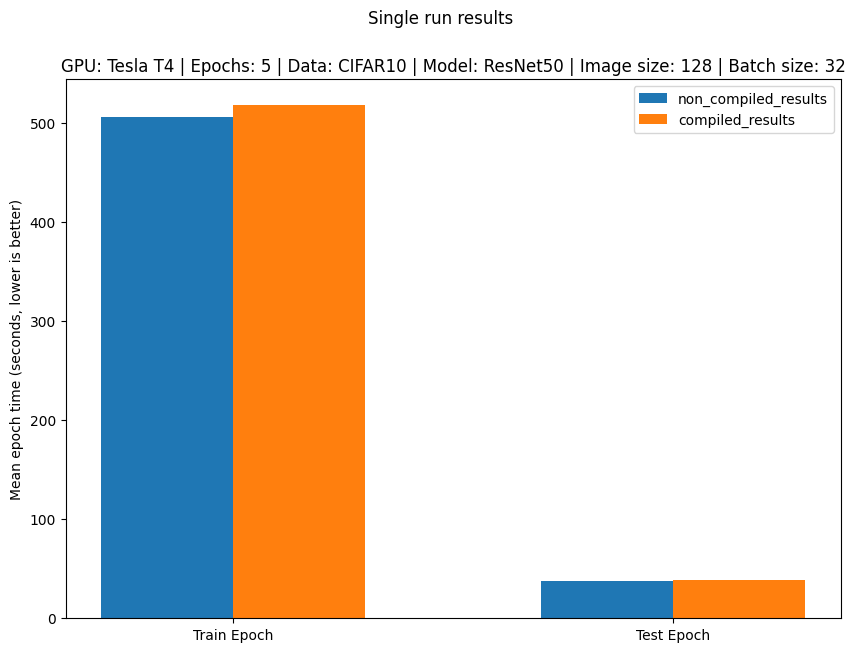

In [41]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_multi_run,
                      save=True)